In [1]:
import clip
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json 
import sys 
from PIL import Image
 
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

sys.path.insert(0, os.path.dirname(os.getcwd()))
import loaders
from utils import scores as sc
from utils import evaluation as ev

In [2]:
# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [3]:
import logging
# Set Logger
logger = logging.getLogger('notebook_logger')
logger.setLevel(logging.DEBUG)
stream_handler = logging.StreamHandler()
stream_handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

# Show One Example of Dataset

2024-05-05 19:45:28,474 - notebook_logger - INFO - Image ID:, 2000000283210
2024-05-05 19:45:28,474 - notebook_logger - INFO - **************************************************
2024-05-05 19:45:28,475 - notebook_logger - INFO - Categories: ['dog', 'chair']
2024-05-05 19:45:28,475 - notebook_logger - INFO - Super Categories: ['animal', 'furniture']
2024-05-05 19:45:28,476 - notebook_logger - INFO - **************************************************
2024-05-05 19:45:28,476 - notebook_logger - INFO - S1: hello how are you today ?
2024-05-05 19:45:28,477 - notebook_logger - INFO - S2: hi , my husband is old and adopted . i love coloring farms in books .
2024-05-05 19:45:28,477 - notebook_logger - INFO - S1: ok that is random . i have never been an artist type
2024-05-05 19:45:28,478 - notebook_logger - INFO - S2: great ! i live on a farm with a dog named trump who watches hockey .
2024-05-05 19:45:28,478 - notebook_logger - INFO - S1: i do not care for dogs . i am waiting for retirement
2

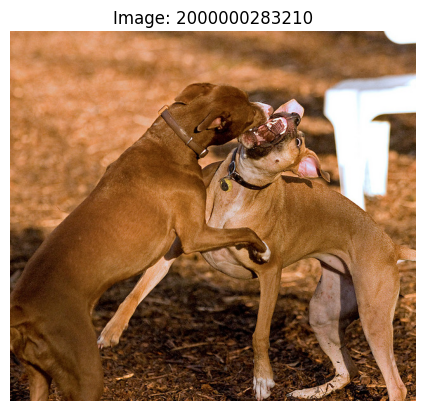

2024-05-05 19:45:28,728 - notebook_logger - INFO - **************************************************
2024-05-05 19:45:29,074 - notebook_logger - INFO - person CLIP feature similarity: 0.2144775390625
2024-05-05 19:45:29,085 - notebook_logger - INFO - animal CLIP feature similarity: 0.2423095703125
2024-05-05 19:45:29,095 - notebook_logger - INFO - vehicle CLIP feature similarity: 0.153564453125
2024-05-05 19:45:29,111 - notebook_logger - INFO - outdoor CLIP feature similarity: 0.179931640625
2024-05-05 19:45:29,122 - notebook_logger - INFO - accessory CLIP feature similarity: 0.2186279296875
2024-05-05 19:45:29,131 - notebook_logger - INFO - sports CLIP feature similarity: 0.2115478515625
2024-05-05 19:45:29,191 - notebook_logger - INFO - kitchen CLIP feature similarity: 0.211669921875
2024-05-05 19:45:29,204 - notebook_logger - INFO - food CLIP feature similarity: 0.1580810546875
2024-05-05 19:45:29,216 - notebook_logger - INFO - furniture CLIP feature similarity: 0.1759033203125
202

In [4]:
# Showing one example
# TODO: Add VSNR for cosine similarity
data_loader = loaders.DataLoader(data_source = "real", logger=logger)
df_table = data_loader.load_dialogue_df()
k = 5
data_loader.showing_example(k)
data_loader.show_clip_similarity(k, df_table, model, preprocess)

# Define OOD Categories below

In [21]:
ood_category = ['vehicle']
ind_category = [x for x in data_loader.supercategories if x not in ood_category]
df_table['OOD'] = df_table['supercategories'].apply(lambda x: 0 if any(item in x for item in ind_category) else 1)
df_table['OOD'].value_counts()

OOD
0    16461
1      519
Name: count, dtype: int64

# Load CLIP features for images and dialogues with Model CLIP ViT-B32

In [9]:
## Dialogue Processing
dialogue_clip = np.load(f'{data_loader.data_dir}/CLIP/mmd_dialogs_truncate/mmd_clip_dialog_features.npy')
df_table['dialogue_clip'] = list(dialogue_clip)

## Image Processing
image_clip = np.load(f'{data_loader.data_dir}/CLIP/mmd_imgs/mmd_clip_img_features.npy')
image_annotation = pd.read_json(f'{data_loader.data_dir}/CLIP/mmd_imgs/mmd_imgs_filenames.json')
image_annotation = image_annotation.rename(columns={0:"img_file"}).join(pd.DataFrame(pd.DataFrame(image_clip.tolist()).apply(np.array, axis=1)))
image_annotation.rename(columns={0:"image_clip"}, inplace=True)
df_table = df_table.merge(image_annotation, on='img_file', how='left')

In [10]:
dialogue_df_segment = pd.read_json(f'{data_loader.data_dir}/CLIP/mmd_dialogs_segment/new_mmd_expand_dialog.json')
dialogue_clip_segment = np.load(f'{data_loader.data_dir}/CLIP/mmd_dialogs_segment/new_mmd_dialog_features.npy')
dialogue_df_segment['dialogue_clip'] = list(dialogue_clip_segment)

In [11]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=ind_category)
df_table['encoded_label'] = list(mlb.fit_transform(df_table['supercategories']))
encoded_df = pd.DataFrame(df_table['encoded_label'].tolist(), columns=ind_category)
df_table = pd.concat([df_table, encoded_df], axis=1)

In [12]:
import torch.nn.functional as F
from tqdm.notebook import tqdm
tqdm.pandas()

if data_loader.data_source == "qa":
    df_table['image_id'] = df_table['image_id'].apply(lambda x: f"COCO_train2014_{int(x):012d}")

categories_clip = {}
for categories in ind_category:
    text = 'Category ' + categories
    text_tokens = clip.tokenize([text]).to(device)  
    with torch.no_grad():
        text_features = model.encode_text(text_tokens).flatten().cpu().numpy()
        categories_clip[categories] = text_features

def calculate_similarity_score(row, type = "image"):
    if type == "image":
        column = 'image_clip'
    elif type == "dialogue":
        column = 'dialogue_clip'

    cosine_sim = 0
    cosine_sim_max = 0
    for categories in ind_category:
        text_features = categories_clip[categories]
        cosine_sim_current = np.dot(text_features, row[column]) / (np.linalg.norm(text_features) * np.linalg.norm(row[column]))
        cosine_sim += cosine_sim_current
        cosine_sim_max = max(cosine_sim_max, cosine_sim_current)


    return cosine_sim, cosine_sim_max

df_table['image_score'], df_table['image_score_max'] = zip(*df_table.progress_apply(calculate_similarity_score, axis=1))
dialogue_df_segment['dialogue_score'], dialogue_df_segment['dialogue_score_max'] = zip(*dialogue_df_segment.progress_apply(calculate_similarity_score, type = "dialogue", axis=1))
df_table['dialogue_score'], df_table['dialogue_score_max'] = zip(*df_table.progress_apply(calculate_similarity_score, axis=1, args=('dialogue',)))

  0%|          | 0/16980 [00:00<?, ?it/s]

  0%|          | 0/61810 [00:00<?, ?it/s]

  0%|          | 0/16980 [00:00<?, ?it/s]

In [13]:
df_table['dialogue_score_segment'] = pd.DataFrame(dialogue_df_segment.groupby('index')['dialogue_score'].mean())['dialogue_score'].values
df_table['dialogue_score_segment_max'] = pd.DataFrame(dialogue_df_segment.groupby('index')['dialogue_score_max'].mean())['dialogue_score_max'].values

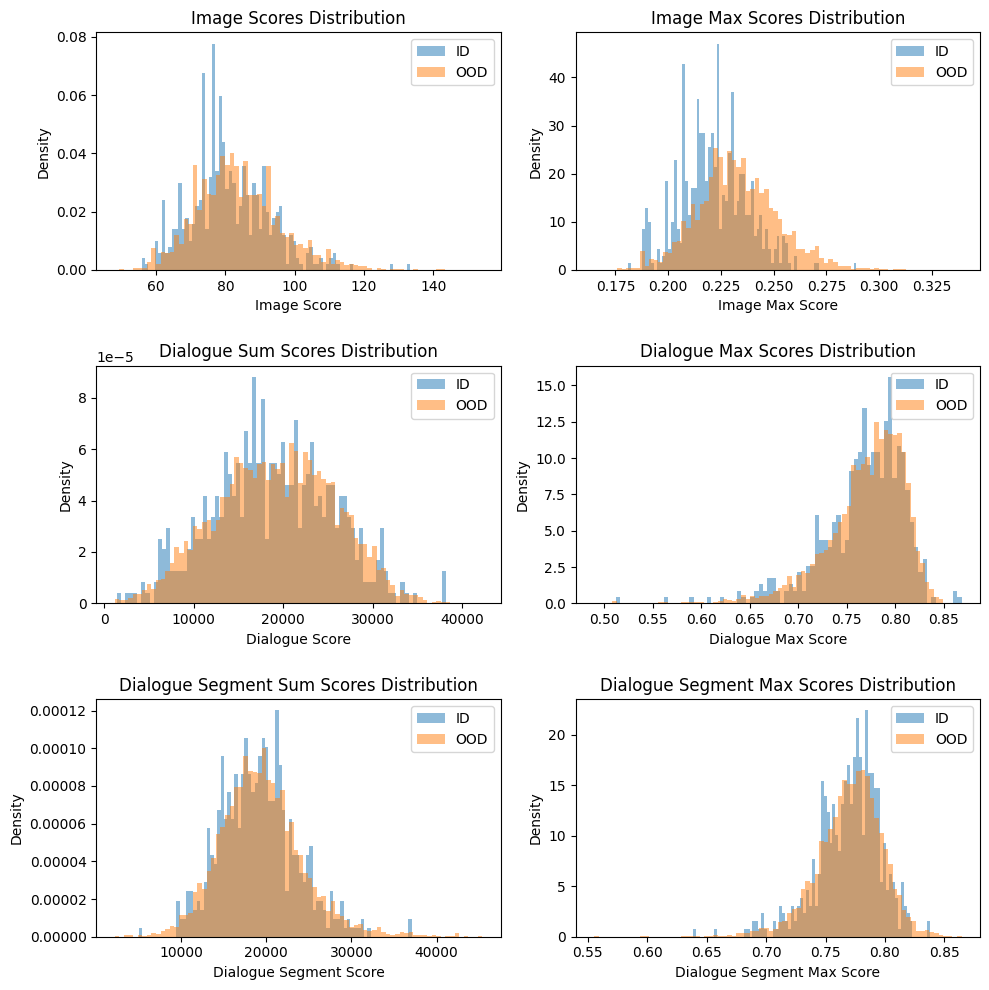

In [14]:
import matplotlib.pyplot as plt

# Assuming df_table is preloaded with the appropriate columns
# Simplifying the code and plotting all histograms in a 2x2 layout

# Create figure and axes for a 2x2 grid
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

# Data for histograms
columns = ['image_score', 'image_score_max', 'dialogue_score', 'dialogue_score_max', 'dialogue_score_segment', 'dialogue_score_segment_max']
titles = ['Image Scores Distribution', 'Image Max Scores Distribution',
          'Dialogue Sum Scores Distribution', 'Dialogue Max Scores Distribution',
          'Dialogue Segment Sum Scores Distribution', 'Dialogue Segment Max Scores Distribution']
x_labels = ['Image Score', 'Image Max Score', 'Dialogue Score', 'Dialogue Max Score', 'Dialogue Segment Score', 'Dialogue Segment Max Score']

# Loop through to plot each histogram in its subplot
for i, ax in enumerate(axs.flatten()):
    ood_scores = df_table[df_table['OOD'] == 1][columns[i]]
    non_ood_scores = df_table[df_table['OOD'] == 0][columns[i]]
    ax.hist(non_ood_scores, bins=80, alpha=0.5, label='ID', density=True)
    ax.hist(ood_scores, bins=80, alpha=0.5, label='OOD', density=True)
    ax.legend(loc='upper right')
    ax.set_title(titles[i])
    ax.set_xlabel(x_labels[i])
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

In [15]:
import importlib
importlib.reload(ev)

<module 'utils.evaluation' from 'f:\\Github\\multimodal_ood\\utils\\evaluation.py'>

In [23]:
def image_text_similarity(row):
    a = row['dialogue_clip']
    b = row['image_clip']
    cos_sim = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return cos_sim
df_table['image_text_similarity'] = df_table.apply(image_text_similarity, axis=1)
df_table['overall_simialrity'] = df_table['image_text_similarity'] * (df_table['image_score'] + 0.0001*df_table['dialogue_score_segment_max'])

In [24]:
print('Image Max:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['image_score_max'].values, 0.95))
print('Image Sum:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['image_score'].values, 0.95))
print('Dialogue Max:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['dialogue_score_max'].values, 0.95))
print('Dialogue Sum:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['dialogue_score'].values, 0.95))
print('Dialogue Segment Max:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['dialogue_score_segment_max'].values, 0.95))
print('Dialogue Segment Sum:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['dialogue_score_segment'].values, 0.95))
print("Overall Max:", ev.fpr_evaluation(df_table['OOD'].values, -df_table['overall_simialrity'].values, 0.95))

Image Max: 0.8250410060142154
Image Sum: 0.9038940526091975
Dialogue Max: 0.9461150598384059
Dialogue Sum: 0.9502460360852925
Dialogue Segment Max: 0.9383391045501488
Dialogue Segment Sum: 0.9351193730636049
Overall Max: 0.8885851406354414


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from models.DNN import model 

model_loader = model.model_loader(logger=logger,
                                  num_epochs=15)

2024-05-05 19:55:23,645 - notebook_logger - INFO - Setting random seed: 42


In [26]:
(
    df_ind_train, 
    df_test, 
    X_train_image, 
    X_test_image, 
    X_train_dialogue, 
    X_test_dialogue, 
    Y_train, 
    Y_test) = model_loader.create_dataset(data_loader, df_table)


In [65]:
model_loader.train_model(X_train_image, Y_train)

  0%|          | 0/15 [00:00<?, ?it/s]

2024-05-05 20:15:32,952 - notebook_logger - INFO - Epoch 1, Train Loss: 0.1524, Train Accuracy: 0.5630
100%|██████████| 15/15 [00:19<00:00,  1.32s/it]


In [66]:
score_type = "msp"
score_sum, score_max = model_loader.evaluate_on_test(X_test_image, 
                                                    Y_test,
                                                    score_type=score_type,
                                                    return_score=True)

df_test[f'{score_type}_sum_image'] = score_sum
df_test[f'{score_type}_max_image'] = score_max

2024-05-05 20:15:52,345 - notebook_logger - INFO - Test Loss: 0.6545, Test Accuracy: 0.7310


TypeError: '<=' not supported between instances of 'NoneType' and 'NoneType'

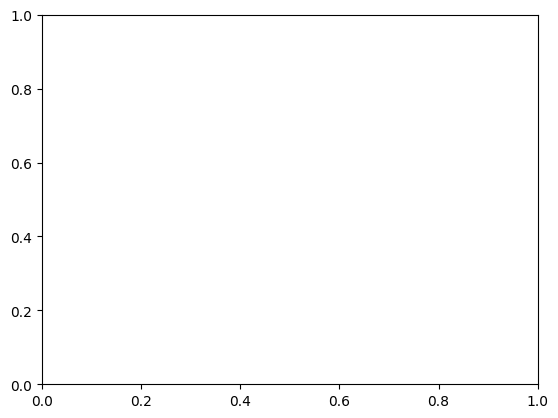

In [68]:
import matplotlib.pyplot as plt

ood_scores = df_test[df_test['OOD'] == 1][f'{score_type}_sum_image']
non_ood_scores = df_test[df_test['OOD'] == 0][f'{score_type}_sum_image']

plt.hist(non_ood_scores, bins=50, alpha=0.5, label='ID', density = 1)
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD', density = 1)
plt.legend(loc='upper right')

plt.title('Energy Distribution')
plt.xlabel('Image Score')
plt.ylabel('Density')

plt.show()

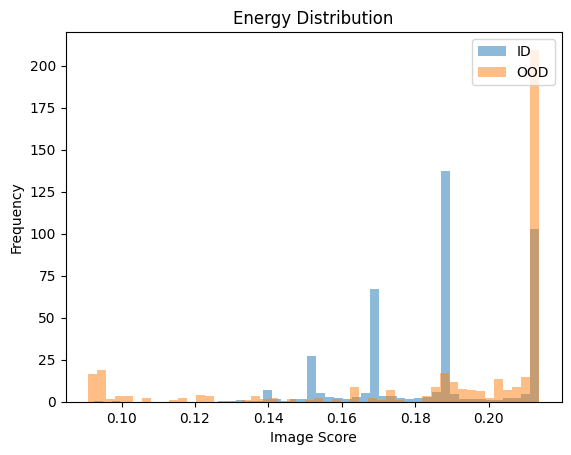

In [69]:
import matplotlib.pyplot as plt

ood_scores = df_test[df_test['OOD'] == 1][f'{score_type}_max_image']
non_ood_scores = df_test[df_test['OOD'] == 0][f'{score_type}_max_image']

plt.hist(non_ood_scores, bins=50, alpha=0.5, label='ID', density = 1)
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD', density = 1)
plt.legend(loc='upper right')

plt.title('Energy Distribution')
plt.xlabel('Image Score')
plt.ylabel('Frequency')

plt.show()

In [70]:
model_loader.num_epochs = 15
model_loader.learning_rate = 0.005

In [71]:
model_loader.train_model(X_train_dialogue, Y_train)

100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


In [72]:
score_sum, score_max = model_loader.evaluate_on_test(X_test_dialogue, 
                                                    Y_test,
                                                    score_type=score_type,
                                                    return_score=True)

2024-05-05 20:16:48,623 - notebook_logger - INFO - Test Loss: 0.4465, Test Accuracy: 0.0513


In [75]:
df_test[f'{score_type}_sum_dialogue'] = score_sum
df_test[f'{score_type}_max_dialogue'] = score_max

TypeError: '<=' not supported between instances of 'NoneType' and 'NoneType'

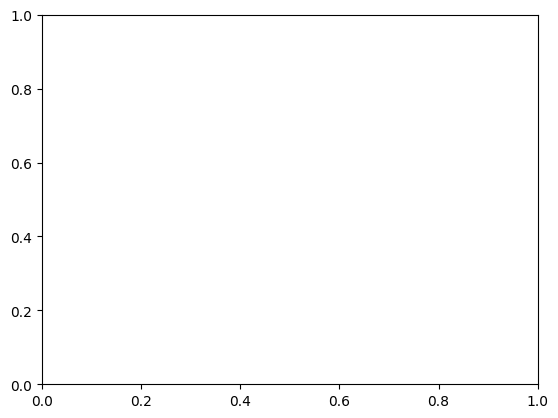

In [74]:
import matplotlib.pyplot as plt

ood_scores = df_test[df_test['OOD'] == 1][f'{score_type}_sum_dialogue']
non_ood_scores = df_test[df_test['OOD'] == 0][f'{score_type}_sum_dialogue']

plt.hist(non_ood_scores, bins=50, alpha=0.5, label='ID', density = 1)
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD', density = 1)
plt.legend(loc='upper right')

plt.title('Energy Distribution')
plt.xlabel('Image Score')
plt.ylabel('Density')

plt.show()

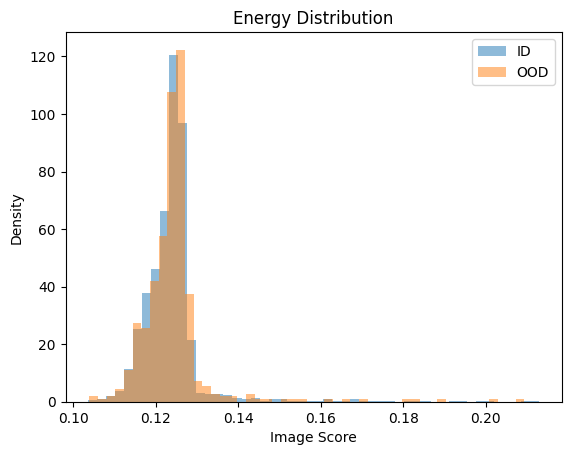

In [76]:
import matplotlib.pyplot as plt

ood_scores = df_test[df_test['OOD'] == 1][f'{score_type}_max_dialogue']
non_ood_scores = df_test[df_test['OOD'] == 0][f'{score_type}_max_dialogue']

plt.hist(non_ood_scores, bins=50, alpha=0.5, label='ID', density = 1)
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD', density = 1)
plt.legend(loc='upper right')

plt.title('Energy Distribution')
plt.xlabel('Image Score')
plt.ylabel('Density')

plt.show()

In [77]:
df_test['overall_simialrity'] = df_test['image_text_similarity'] * (df_test[f'{score_type}_max_image'] + df_test[f'{score_type}_max_dialogue'])

In [59]:
df_test['overall_simialrity'] = df_test['image_text_similarity'] * (df_test['image_score'] + 0.001*df_test['dialogue_score'])

In [60]:
model_loader.logger.info(ev.fpr_evaluation(df_test['OOD'].values, -df_test['image_score_max'].values, 0.95))
model_loader.logger.info(ev.fpr_evaluation(df_test['OOD'].values, -df_test['image_score'].values, 0.95))
model_loader.logger.info(ev.fpr_evaluation(df_test['OOD'].values, -df_test['dialogue_score_max'].values, 0.95))
model_loader.logger.info(ev.fpr_evaluation(df_test['OOD'].values, -df_test['dialogue_score'].values, 0.95))
model_loader.logger.info(ev.fpr_evaluation(df_test['OOD'].values, -df_test['dialogue_score_segment_max'].values, 0.95))
model_loader.logger.info(ev.fpr_evaluation(df_test['OOD'].values, -df_test['dialogue_score_segment'].values, 0.95))
model_loader.logger.info(ev.fpr_evaluation(df_test['OOD'].values, -df_test['overall_simialrity'].values, 0.95))

2024-05-05 20:13:54,102 - notebook_logger - INFO - 0.818955042527339
2024-05-05 20:13:54,103 - notebook_logger - INFO - 0.9076549210206561
2024-05-05 20:13:54,104 - notebook_logger - INFO - 0.93955042527339
2024-05-05 20:13:54,105 - notebook_logger - INFO - 0.9389428918590522
2024-05-05 20:13:54,106 - notebook_logger - INFO - 0.93681652490887
2024-05-05 20:13:54,107 - notebook_logger - INFO - 0.9319562575941677
2024-05-05 20:13:54,108 - notebook_logger - INFO - 0.8718104495747266


In [80]:
model_loader.logger.info(ev.fpr_evaluation(df_test['OOD'].values, -df_test[f'{score_type}_max_image'].values, 0.95))
model_loader.logger.info(ev.fpr_evaluation(df_test['OOD'].values, -df_test[f'{score_type}_max_dialogue'].values, 0.95))
model_loader.logger.info(ev.fpr_evaluation(df_test['OOD'].values, -df_test['overall_simialrity'].values, 0.95))

2024-05-05 20:17:44,225 - notebook_logger - INFO - 0.9171483622350675
2024-05-05 20:17:44,226 - notebook_logger - INFO - 0.9547387606318347
2024-05-05 20:17:44,226 - notebook_logger - INFO - 0.9015795868772782


In [64]:
model_loader.logger.info(ev.fpr_evaluation(df_test['OOD'].values, df_test['energy_sum_image'].values, 0.95))
model_loader.logger.info(ev.fpr_evaluation(df_test['OOD'].values, df_test['energy_max_image'].values, 0.95))
model_loader.logger.info(ev.fpr_evaluation(df_test['OOD'].values, df_test['energy_sum_dialogue'].values, 0.95))
model_loader.logger.info(ev.fpr_evaluation(df_test['OOD'].values, df_test['energy_max_dialogue'].values, 0.95))
model_loader.logger.info(ev.fpr_evaluation(df_test['OOD'].values, df_test['overall_simialrity'].values, 0.95))

2024-05-05 20:15:04,048 - notebook_logger - INFO - 0.2712636695018226
2024-05-05 20:15:04,048 - notebook_logger - INFO - 0.39003645200486026
2024-05-05 20:15:04,049 - notebook_logger - INFO - 0.9620291616038882
2024-05-05 20:15:04,050 - notebook_logger - INFO - 0.9729647630619684
2024-05-05 20:15:04,051 - notebook_logger - INFO - 0.37910085054678005


In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score

np.random.seed(42) 
n_samples = 100
n_ood = 20
ood_scores = np.concatenate([
    np.random.uniform(low=0.1, high=0.4, size=n_samples - n_ood), 
    np.random.uniform(low=0.6, high=0.9, size=n_ood)             
])
ood_labels = np.concatenate([
    np.zeros(n_samples - n_ood), 
    np.ones(n_ood)               
])
auroc = roc_auc_score(ood_labels, ood_scores)
print("AUROC score:", auroc)

In [ ]:
ood_scores